# <font style="color:blue">Train a Custom Object Detector using DarkNet YOLOv3</font>

# <font style="color:blue">Change Runtime Type</font>
Before proceeding, make sure that the notebook is running on the GPU. Go to Runtime -> Change runtime type -> Select hardware Accelerator as GPU.

# <font style="color:blue">1. Link Google Drive</font>


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/work/OpenCV_Courses/CV_II_105/Project3_Train_Face_Mask_Detector/


/content/drive/MyDrive/work/OpenCV_Courses/CV_II_105/Project3_Train_Face_Mask_Detector


# <font style="color:blue">2. Clone the DarkNet Repository </font>
We will use Alexey's darknet fork which has many modifications and improvements and is actively maintained by him.

In [ ]:
!git clone https://github.com/AlexeyAB/darknet.git

Cloning into 'darknet'...
remote: Enumerating objects: 1, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 14737 (delta 0), reused 1 (delta 0), pack-reused 14736
Receiving objects: 100% (14737/14737), 13.25 MiB | 6.67 MiB/s, done.
Resolving deltas: 100% (10023/10023), done.
Checking out files: 100% (2023/2023), done.


# <font style="color:blue">3. Compile DarkNet</font>


We will first make some changes to the Makefile before we compile. Specifically, we will enable the following:
1. Build darknet with OpenCV
1. Build with CUDA enabled
1. Build with cuDNN enabled.

In [ ]:
%cd darknet

/content/drive/My Drive/work/OpenCV_Courses/CV_II_105/Project3_Train_Face_Mask_Detector/darknet


In [ ]:
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile

print("Building. . . It might take 2-3 minutes")

!make &> build_log.txt

Building. . . It might take 2-3 minutes


## <font style="color:blue">4 Prepare dataset files</font>
We need to create a txt file which contains the path to the images. These files will be used while setting up the training. 

The data is split into train and test in the ratio of 80:20. So, we will use 80% of the data for training and the rest for testing after a few iterations of training.

In [ ]:
#We have the data already available after direct download
%mkdir dataset
%cp ../mask_no-mask_dataset.zip dataset



In [ ]:
%cd dataset/


/content/drive/My Drive/work/OpenCV_Courses/CV_II_105/Project3_Train_Face_Mask_Detector/darknet/dataset


In [ ]:
!unzip mask_no-mask_dataset.zip &> /dev/null 

In [ ]:
%rm mask_no-mask_dataset.zip

In [ ]:
%cd ..

/content/drive/My Drive/work/OpenCV_Courses/CV_II_105/Project3_Train_Face_Mask_Detector/darknet


In [ ]:
import random
import os
import subprocess
import sys

image_dir = "dataset"
f_val = open("data_test.txt", 'w')
f_train = open("data_train.txt", 'w')

path, dirs, files = next(os.walk(image_dir))
data_size = len(files)

ind = 0
data_test_size = int(0.2 * data_size)
test_array = random.sample(range(data_size), k=data_test_size)

for f in os.listdir(image_dir):
    if(f.split(".")[-1] == "jpg") or (f.split(".")[-1] == "jpeg") or (f.split(".")[-1] == "png"):
        ind += 1
        
        if ind in test_array:
            f_val.write(image_dir+'/'+f+'\n')
        else:
            f_train.write(image_dir+'/'+f+'\n')

f_train.close()
f_val.close()

# <font style="color:blue">5. Download weights for Convolutional backbone</font>
When you train your own object detector, it is a good idea to leverage existing models trained on very large datasets even though the large dataset may not contain the object you are trying to detect. This process is called transfer learning.

Instead of learning from scratch, we use a pre-trained model which contains convolutional weights trained on ImageNet. Using these weights as our starting weights, our network can learn faster. We will use the pre-trained convolutional backbone. 

We will download the weights file from our server as the author's server seemed slow. If you face any issues, you can download the file from the link given in the code below.

In [ ]:
# Original File : https://pjreddie.com/media/files/darknet53.conv.74
!wget "https://www.dropbox.com/s/18dwbfth7prbf0h/darknet53.conv.74?dl=1" -O darknet53.conv.74

--2021-04-27 16:24:17--  https://www.dropbox.com/s/18dwbfth7prbf0h/darknet53.conv.74?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:601a:18::a27d:712
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/18dwbfth7prbf0h/darknet53.conv.74 [following]
--2021-04-27 16:24:18--  https://www.dropbox.com/s/dl/18dwbfth7prbf0h/darknet53.conv.74
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc289d7c099ebddbb9a683449293.dl.dropboxusercontent.com/cd/0/get/BNZGqmROyQn8iaVCCmOruQ88DG-iuTLLodpaUxtxrGDjUDgFQ0PFdXtgKALFu7L7rPvfRhMhtbU9vwBCWEMQCLSTtsQs0qAZQuCtgu9aSuB3420BGgSK_Eay7EjHxlgddCnYFOOeAQ0UD8LQd6JSWNSz/file?dl=1# [following]
--2021-04-27 16:24:18--  https://uc289d7c099ebddbb9a683449293.dl.dropboxusercontent.com/cd/0/get/BNZGqmROyQn8iaVCCmOruQ88DG-iuTLLodpaUxtxrGDjUDgFQ0PFdXtgKALFu7L7rPvfRhMht

## <font style="color:blue">6.1. Data Setup</font>
In the file **`yolov3-mask-setup.data`**, we need to provide information about the specifications for our object detector and some relevant paths.

The contents of the file are as follows:
```
classes = 2
train  = data_train.txt
valid  = data_test.txt
names = class.names
backup = backup/
```
The classes parameter needs the number of classes. In our case, it is 2.

You need to provide the absolute paths of the files **`data_train.txt`** and **`data_test.txt`** generated earlier, which have the list of files to be used for training(train parameter) and validation(valid parameter) respectively.

The names field represents the path of a file which contains the names of all the classes. We have included the **`class.names`** file which contains the classes name **`Mask`** and **`No-Mask`**. You will need to provide its absolute path in your machine here.

Lastly, for the **`backup`** parameter, we need to give the path to an existing directory where we can store the intermediate weights files as the training progresses.

## <font style="color:blue">6.2. Training Config File</font>
Along with the yolov3-mask-setup.data and class.names files, YOLOv3 also needs a configuration file **`yolov3-mask-train.cfg`**. It is based on the demo configuration file, yolov3-voc.cfg (comes with darknet code), which was used to train on the VOC dataset. All the important training parameters are stored in this configuration file. Let us understand what they mean and what values to set them to.

### <font style="color:green">6.2.1 Batch hyper-parameter in YOLOv3</font>
Let’s learn more about batch and subdivision parameter.
```
[net]
# Testing
# batch=1
# subdivisions=1
# Training
batch=64
subdivisions=16
```
The batch parameter indicates the batch size used during training.

Our training set contains a few hundred images, but it is not uncommon to train on million of images. The training process involves iteratively updating the weights of the neural network based on how many mistakes it is making on the training dataset.

It is impractical (and unnecessary) to use all images in the training set at once to update the weights. So, a small subset of images is used in one iteration, and this subset is called the batch size.

When the batch size is set to 64, it means 64 images are used in one iteration to update the parameters of the neural network.

### <font style="color:green">6.2.2 Subdivisions configuration parameter in YOLOv3</font>
Even though you may want to use a batch size of 64 for training your neural network, you may not have a GPU with enough memory to use a batch size of 64. Fortunately, Darknet allows you to specify a variable called subdivisions that lets you process a fraction of the batch size at one time on your GPU.

You can start the training with subdivisions=1, and if you get an Out of memory error, increase the subdivisions parameter by multiples of 2(e.g. 2, 4, 8, 16) till the training proceeds successfully. The GPU will process batch/subdivision number of images at any time, but the full batch or iteration would be complete only after all the 64 (as set above) images are processed.

During testing, both batch and subdivision are set to 1.

### <font style="color:green">6.2.3 Width, Height, Channels</font>
These configuration parameters specify the input image size and the number of channels.

```
width=416
height=416
channels=3
```
The input training images are first resized to width x height before training. Here we use the default values of 416×416. The results might improve if we increase it to 608×608, but it would take longer to train too. channels=3 indicates that we would be processing 3-channel RGB input images.

### <font style="color:green">6.2.4 Momentum and Decay</font>
The configuration file contains a few parameters that control how the weight is updated.
```
momentum=0.9
decay=0.0005
```
In the previous section, we mentioned how the weights of a neural network are updated based on a small batch of images and not the entire dataset. Because of this reason, the weight updates fluctuate quite a bit. That is why a parameter momentum is used to penalize large weight changes between iterations.

A typical neural network has millions of weights and therefore they can easily overfit any training data. Overfitting simply means it will do very well on training data and poorly on test data. It is almost like the neural network has memorized the answer to all images in the training set, but really not learned the underlying concept. One of the ways to mitigate this problem is to penalize large value for weights. The parameter decay controls this penalty term. The default value works just fine, but you may want to tweak this if you notice overfitting.

### <font style="color:green">6.2.5 Learning Rate, Steps, Scales, Burn In (warm-up)</font>
```
learning_rate=0.001
policy=steps
steps=800, 900
scales=.1, .1
burn_in=100
```
The parameter learning rate controls how aggressively we should learn based on the current batch of data. Typically this is a number between 0.01 and 0.0001.

At the beginning of the training process, we are starting with zero information and so the learning rate needs to be high. But as the neural network sees a lot of data, the weights need to change less aggressively. In other words, the learning rate needs to be decreased over time. In the configuration file, this decrease in learning rate is accomplished by first specifying that our learning rate decreasing policy is steps. In the above example, the learning rate will start from 0.001 and remain constant for 800 iterations, and then it will multiply by scales to get the new learning rate. We could have also specified multiple steps and scales.

In the previous paragraph, we mentioned that the learning rate needs to be high in the beginning and low later on. While that statement is largely true, it has been empirically found that the training speed tends to increase if we have a lower learning rate for a short period of time at the very beginning. This is controlled by the burn_in parameter. Sometimes this **`burn-in`** period is also called warm-up period.

### <font style="color:green">6.2.6 Data augmentation</font>
We know data collection takes a long time and it is difficult to find high quality annotated data. We want to make maximum use of this data by cooking up new data. This process is called data augmentation. For example, an image of the ambulance rotated by 5 degrees is still an image of a ambulance. The angle parameter in the configuration file allows you to randomly rotate the given image by ± angle.

Similarly, if we transform the colors of the entire picture using saturation, exposure, and hue, it is still a picture of the ambulance.
```
angle=0
saturation = 1.5
exposure = 1.5
hue=.1
```
We used the default values for training.

### <font style="color:green">6.2.7 Number of iterations</font>
Finally, we need to specify how many iterations should the training process be run for.
```
max_batches=1000
```

For multi-class object detectors, the max_batches number is higher, i.e. we need to run for more number of batches(e.g. in yolov3-voc.cfg). For an n-classes object detector, it is advisable to run the training for at least 2000*n batches. In our case, 1000 seemed like a safe number for max_batches. 

You should try to change the parameter and see how it performs.

### <font style="color:green">6.2.8 Change filters parameter in conv layers [Important for multiple objects]</font>
Change the filters parameter in the convolutional layer just before the yolo layer according to the formula 

**`filters=( classes + 5 ) * 3`**

Since we are using classes = 2, thus, #filters in our case is 21. You should make this change if you are dealing with more classes.


## <font style="color:blue">6.3. Names file </font>
We need to specify the names of the classes in the **`.names`** file. In our case, there is only 1 class and thus, only Ambulance is added to that file.

# <font style="color:blue">7. Start Training </font>
For starting training using darknet, we need to execute the following command. Here we are specifying the
1. path to the setup file, 
1. path to config file, 
1. path to convolutional weights file 

and also passing some flags such as:

- **`dont_show`** which wont display the graphs. This is required for Colab since it does not have a display and it will crash if it tries to display, not if you run the notebook on your local system.
- **`map`** - this will calculate mAP - mean average precision for the test data which we have specified using the data_test.txt file which contains 20% of our data.

In [ ]:
%pwd
!chmod +x ./darknet

In [ ]:
!./darknet detector train  yolov3-mask-setup.data yolov3-mask-train.cfg darknet53.conv.74 -dont_show -clear -map 2> train_log_yolov3.txt

 Prepare additional network for mAP calculation...
net.optimized_memory = 0 
mini_batch = 1, batch = 16, time_steps = 1, train = 0 
yolov3-mask-train
net.optimized_memory = 0 
mini_batch = 4, batch = 64, time_steps = 1, train = 1 

 seen 64, trained: 0 K-images (0 Kilo-batches_64) 
Learning Rate: 0.001, Momentum: 0.9, Decay: 0.0005
 Detection layer: 82 - type = 28 
 Detection layer: 94 - type = 28 
 Detection layer: 106 - type = 28 
Resizing, random_coef = 1.40 

 608 x 608 
 try to allocate additional workspace_size = 0.04 MB 
 CUDA allocate done! 
Loaded: 0.000046 seconds

 (next mAP calculation at 100 iterations) 
 1: 6304.218262, 6304.218262 avg loss, 0.000000 rate, 26.374613 seconds, 64 images, -1.000000 hours left
Loaded: 0.000081 seconds

 (next mAP calculation at 100 iterations) 
 2: 6305.595215, 6304.355957 avg loss, 0.000000 rate, 27.081117 seconds, 128 images, 7.318977 hours left
Loaded: 0.000058 seconds

 (next mAP calculation at 100 iterations) 
 3: 6312.628906, 6305.18310


 (next mAP calculation at 100 iterations) 
 43: 4.746771, 210.915070 avg loss, 0.000034 rate, 9.952111 seconds, 2752 images, 6.343846 hours left
Loaded: 0.000065 seconds

 (next mAP calculation at 100 iterations) 
 44: 5.699660, 190.393524 avg loss, 0.000037 rate, 9.962178 seconds, 2816 images, 6.306864 hours left
Loaded: 0.000062 seconds

 (next mAP calculation at 100 iterations) 
 45: 6.459967, 172.000168 avg loss, 0.000041 rate, 9.909230 seconds, 2880 images, 6.270251 hours left
Loaded: 0.000045 seconds

 (next mAP calculation at 100 iterations) 
 46: 5.198561, 155.320007 avg loss, 0.000045 rate, 9.989234 seconds, 2944 images, 6.233836 hours left
Loaded: 0.000067 seconds

 (next mAP calculation at 100 iterations) 
 47: 6.971247, 140.485138 avg loss, 0.000049 rate, 10.021830 seconds, 3008 images, 6.197969 hours left
Loaded: 0.000047 seconds

 (next mAP calculation at 100 iterations) 
 48: 3.798444, 126.816467 avg loss, 0.000053 rate, 9.906142 seconds, 3072 images, 6.162520 hours lef


 (next mAP calculation at 100 iterations) 
 89: 3.102545, 6.352613 avg loss, 0.000627 rate, 9.930373 seconds, 5696 images, 5.427505 hours left
Loaded: 0.000072 seconds

 (next mAP calculation at 100 iterations) 
 90: 3.111501, 6.028502 avg loss, 0.000656 rate, 9.912911 seconds, 5760 images, 5.398359 hours left
Resizing, random_coef = 1.40 

 544 x 544 
 try to allocate additional workspace_size = 0.04 MB 
 CUDA allocate done! 
Loaded: 0.000045 seconds

 (next mAP calculation at 100 iterations) 
 91: 5.150086, 5.940660 avg loss, 0.000686 rate, 22.091924 seconds, 5824 images, 5.369434 hours left
Loaded: 0.000067 seconds

 (next mAP calculation at 100 iterations) 
 92: 3.602234, 5.706818 avg loss, 0.000716 rate, 22.268830 seconds, 5888 images, 5.371522 hours left
Loaded: 0.000045 seconds

 (next mAP calculation at 100 iterations) 
 93: 6.189290, 5.755065 avg loss, 0.000748 rate, 22.717181 seconds, 5952 images, 5.373974 hours left
Loaded: 0.000067 seconds

 (next mAP calculation at 100 it


 (next mAP calculation at 200 iterations) 
 Last accuracy mAP@0.5 = 9.90 %, best = 9.90 % 
 123: 5.104225, 4.842129 avg loss, 0.001000 rate, 13.629370 seconds, 7872 images, 4.876681 hours left
Loaded: 0.000052 seconds

 (next mAP calculation at 200 iterations) 
 Last accuracy mAP@0.5 = 9.90 %, best = 9.90 % 
 124: 2.909312, 4.648847 avg loss, 0.001000 rate, 13.458143 seconds, 7936 images, 4.861117 hours left
Loaded: 0.000073 seconds

 (next mAP calculation at 200 iterations) 
 Last accuracy mAP@0.5 = 9.90 %, best = 9.90 % 
 125: 2.979927, 4.481955 avg loss, 0.001000 rate, 13.417632 seconds, 8000 images, 4.845254 hours left
Loaded: 0.000072 seconds

 (next mAP calculation at 200 iterations) 
 Last accuracy mAP@0.5 = 9.90 %, best = 9.90 % 
 126: 3.765921, 4.410352 avg loss, 0.001000 rate, 13.472040 seconds, 8064 images, 4.829414 hours left
Loaded: 0.000080 seconds

 (next mAP calculation at 200 iterations) 
 Last accuracy mAP@0.5 = 9.90 %, best = 9.90 % 
 127: 2.827078, 4.252024 avg los


 (next mAP calculation at 200 iterations) 
 Last accuracy mAP@0.5 = 9.90 %, best = 9.90 % 
 159: 3.606892, 3.804550 avg loss, 0.001000 rate, 11.653284 seconds, 10176 images, 4.518369 hours left
Loaded: 0.000065 seconds

 (next mAP calculation at 200 iterations) 
 Last accuracy mAP@0.5 = 9.90 %, best = 9.90 % 
 160: 3.797556, 3.803850 avg loss, 0.001000 rate, 11.598126 seconds, 10240 images, 4.500409 hours left
Resizing, random_coef = 1.40 

 416 x 416 
 try to allocate additional workspace_size = 12.46 MB 
 CUDA allocate done! 
Loaded: 0.000048 seconds

 (next mAP calculation at 200 iterations) 
 Last accuracy mAP@0.5 = 9.90 %, best = 9.90 % 
 161: 3.064366, 3.729902 avg loss, 0.001000 rate, 13.156240 seconds, 10304 images, 4.482467 hours left
Loaded: 0.000075 seconds

 (next mAP calculation at 200 iterations) 
 Last accuracy mAP@0.5 = 9.90 %, best = 9.90 % 
 162: 4.773433, 3.834255 avg loss, 0.001000 rate, 13.702492 seconds, 10368 images, 4.468304 hours left
Loaded: 0.000074 seconds



 (next mAP calculation at 200 iterations) 
 Last accuracy mAP@0.5 = 9.90 %, best = 9.90 % 
 195: 3.181489, 3.723835 avg loss, 0.001000 rate, 24.938796 seconds, 12480 images, 4.328078 hours left
Loaded: 0.000066 seconds

 (next mAP calculation at 200 iterations) 
 Last accuracy mAP@0.5 = 9.90 %, best = 9.90 % 
 196: 2.333048, 3.584756 avg loss, 0.001000 rate, 24.764217 seconds, 12544 images, 4.340564 hours left
Loaded: 0.000071 seconds

 (next mAP calculation at 200 iterations) 
 Last accuracy mAP@0.5 = 9.90 %, best = 9.90 % 
 197: 4.164323, 3.642713 avg loss, 0.001000 rate, 25.147703 seconds, 12608 images, 4.352465 hours left
Loaded: 0.000073 seconds

 (next mAP calculation at 200 iterations) 
 Last accuracy mAP@0.5 = 9.90 %, best = 9.90 % 
 198: 3.313154, 3.609757 avg loss, 0.001000 rate, 24.965832 seconds, 12672 images, 4.365034 hours left
Loaded: 0.000070 seconds

 (next mAP calculation at 200 iterations) 
 Last accuracy mAP@0.5 = 9.90 %, best = 9.90 % 
 199: 2.639652, 3.512747 avg


 (next mAP calculation at 300 iterations) 
 Last accuracy mAP@0.5 = 43.25 %, best = 43.25 % 
 226: 3.930080, 3.632239 avg loss, 0.001000 rate, 15.142412 seconds, 14464 images, 4.281630 hours left
Loaded: 0.000064 seconds

 (next mAP calculation at 300 iterations) 
 Last accuracy mAP@0.5 = 43.25 %, best = 43.25 % 
 227: 4.173393, 3.686355 avg loss, 0.001000 rate, 15.121778 seconds, 14528 images, 4.271370 hours left
Loaded: 0.000050 seconds

 (next mAP calculation at 300 iterations) 
 Last accuracy mAP@0.5 = 43.25 %, best = 43.25 % 
 228: 3.194250, 3.637144 avg loss, 0.001000 rate, 15.026383 seconds, 14592 images, 4.261126 hours left
Loaded: 0.000049 seconds

 (next mAP calculation at 300 iterations) 
 Last accuracy mAP@0.5 = 43.25 %, best = 43.25 % 
 229: 3.937047, 3.667135 avg loss, 0.001000 rate, 15.130071 seconds, 14656 images, 4.250738 hours left
Loaded: 0.000059 seconds

 (next mAP calculation at 300 iterations) 
 Last accuracy mAP@0.5 = 43.25 %, best = 43.25 % 
 230: 3.178995, 3.


 (next mAP calculation at 300 iterations) 
 Last accuracy mAP@0.5 = 43.25 %, best = 43.25 % 
 261: 2.535698, 3.361354 avg loss, 0.001000 rate, 24.338075 seconds, 16704 images, 3.878685 hours left
Loaded: 0.000066 seconds

 (next mAP calculation at 300 iterations) 
 Last accuracy mAP@0.5 = 43.25 %, best = 43.25 % 
 262: 3.132993, 3.338518 avg loss, 0.001000 rate, 25.057519 seconds, 16768 images, 3.889859 hours left
Loaded: 0.000069 seconds

 (next mAP calculation at 300 iterations) 
 Last accuracy mAP@0.5 = 43.25 %, best = 43.25 % 
 263: 1.970484, 3.201714 avg loss, 0.001000 rate, 24.770796 seconds, 16832 images, 3.902329 hours left
Loaded: 0.000068 seconds

 (next mAP calculation at 300 iterations) 
 Last accuracy mAP@0.5 = 43.25 %, best = 43.25 % 
 264: 4.418356, 3.323379 avg loss, 0.001000 rate, 25.273531 seconds, 16896 images, 3.914017 hours left
Loaded: 0.000070 seconds

 (next mAP calculation at 300 iterations) 
 Last accuracy mAP@0.5 = 43.25 %, best = 43.25 % 
 265: 3.446019, 3.


 (next mAP calculation at 300 iterations) 
 Last accuracy mAP@0.5 = 43.25 %, best = 43.25 % 
 297: 2.775749, 3.492136 avg loss, 0.001000 rate, 9.948515 seconds, 19008 images, 3.925713 hours left
Loaded: 0.000042 seconds

 (next mAP calculation at 300 iterations) 
 Last accuracy mAP@0.5 = 43.25 %, best = 43.25 % 
 298: 2.619222, 3.404845 avg loss, 0.001000 rate, 9.929937 seconds, 19072 images, 3.905883 hours left
Loaded: 0.000075 seconds

 (next mAP calculation at 300 iterations) 
 Last accuracy mAP@0.5 = 43.25 %, best = 43.25 % 
 299: 3.466191, 3.410980 avg loss, 0.001000 rate, 9.979487 seconds, 19136 images, 3.886188 hours left
Loaded: 0.000070 seconds

 (next mAP calculation at 300 iterations) 
 Last accuracy mAP@0.5 = 43.25 %, best = 43.25 % 
 300: 4.225639, 3.492445 avg loss, 0.001000 rate, 9.993581 seconds, 19200 images, 3.866759 hours left
Resizing to initial size: 416 x 416  try to allocate additional workspace_size = 12.46 MB 
 CUDA allocate done! 

 calculation mAP (mean aver


 (next mAP calculation at 400 iterations) 
 Last accuracy mAP@0.5 = 52.30 %, best = 52.30 % 
 328: 2.317845, 3.129276 avg loss, 0.001000 rate, 11.607212 seconds, 20992 images, 3.468666 hours left
Loaded: 0.000079 seconds

 (next mAP calculation at 400 iterations) 
 Last accuracy mAP@0.5 = 52.30 %, best = 52.30 % 
 329: 2.483027, 3.064651 avg loss, 0.001000 rate, 11.596602 seconds, 21056 images, 3.455646 hours left
Loaded: 0.000074 seconds

 (next mAP calculation at 400 iterations) 
 Last accuracy mAP@0.5 = 52.30 %, best = 52.30 % 
 330: 3.703347, 3.128520 avg loss, 0.001000 rate, 11.773931 seconds, 21120 images, 3.442705 hours left
Resizing, random_coef = 1.40 

 480 x 480 
 try to allocate additional workspace_size = 0.04 MB 
 CUDA allocate done! 
Loaded: 0.000053 seconds

 (next mAP calculation at 400 iterations) 
 Last accuracy mAP@0.5 = 52.30 %, best = 52.30 % 
 331: 2.450844, 3.060753 avg loss, 0.001000 rate, 17.171060 seconds, 21184 images, 3.430190 hours left
Loaded: 0.000061 s


 (next mAP calculation at 400 iterations) 
 Last accuracy mAP@0.5 = 52.30 %, best = 52.30 % 
 363: 2.017681, 3.068218 avg loss, 0.001000 rate, 13.387622 seconds, 23232 images, 3.132374 hours left
Loaded: 0.000071 seconds

 (next mAP calculation at 400 iterations) 
 Last accuracy mAP@0.5 = 52.30 %, best = 52.30 % 
 364: 2.880215, 3.049418 avg loss, 0.001000 rate, 13.465426 seconds, 23296 images, 3.124739 hours left
Loaded: 0.000083 seconds

 (next mAP calculation at 400 iterations) 
 Last accuracy mAP@0.5 = 52.30 %, best = 52.30 % 
 365: 2.989910, 3.043467 avg loss, 0.001000 rate, 13.471604 seconds, 23360 images, 3.117281 hours left
Loaded: 0.000070 seconds

 (next mAP calculation at 400 iterations) 
 Last accuracy mAP@0.5 = 52.30 %, best = 52.30 % 
 366: 2.938013, 3.032922 avg loss, 0.001000 rate, 13.509962 seconds, 23424 images, 3.109871 hours left
Loaded: 0.000073 seconds

 (next mAP calculation at 400 iterations) 
 Last accuracy mAP@0.5 = 52.30 %, best = 52.30 % 
 367: 4.526602, 3.


 (next mAP calculation at 400 iterations) 
 Last accuracy mAP@0.5 = 52.30 %, best = 52.30 % 
 399: 2.535413, 3.016596 avg loss, 0.001000 rate, 11.650970 seconds, 25536 images, 3.009947 hours left
Loaded: 0.000085 seconds

 (next mAP calculation at 400 iterations) 
 Last accuracy mAP@0.5 = 52.30 %, best = 52.30 % 
 400: 3.646997, 3.079636 avg loss, 0.001000 rate, 11.694106 seconds, 25600 images, 2.999298 hours left
Resizing to initial size: 416 x 416  try to allocate additional workspace_size = 12.46 MB 
 CUDA allocate done! 

 calculation mAP (mean average precision)...
 Detection layer: 82 - type = 28 
 Detection layer: 94 - type = 28 
 Detection layer: 106 - type = 28 

 detections_count = 12227, unique_truth_count = 1368  
class_id = 0, name = Mask, ap = 76.98%   	 (TP = 282, FP = 70) 
class_id = 1, name = No-Mask, ap = 40.50%   	 (TP = 200, FP = 89) 

 for conf_thresh = 0.25, precision = 0.75, recall = 0.35, F1-score = 0.48 
 for conf_thresh = 0.25, TP = 482, FP = 159, FN = 886, a


 (next mAP calculation at 500 iterations) 
 Last accuracy mAP@0.5 = 58.74 %, best = 58.74 % 
 430: 2.368120, 3.242005 avg loss, 0.001000 rate, 11.587060 seconds, 27520 images, 2.765619 hours left
Resizing, random_coef = 1.40 

 448 x 448 
 try to allocate additional workspace_size = 0.04 MB 
 CUDA allocate done! 
Loaded: 0.000049 seconds

 (next mAP calculation at 500 iterations) 
 Last accuracy mAP@0.5 = 58.74 %, best = 58.74 % 
 431: 4.084438, 3.326249 avg loss, 0.001000 rate, 14.951093 seconds, 27584 images, 2.756309 hours left
Loaded: 0.000078 seconds

 (next mAP calculation at 500 iterations) 
 Last accuracy mAP@0.5 = 58.74 %, best = 58.74 % 
 432: 2.391856, 3.232809 avg loss, 0.001000 rate, 15.008839 seconds, 27648 images, 2.752377 hours left
Loaded: 0.000068 seconds

 (next mAP calculation at 500 iterations) 
 Last accuracy mAP@0.5 = 58.74 %, best = 58.74 % 
 433: 2.444820, 3.154010 avg loss, 0.001000 rate, 15.049610 seconds, 27712 images, 2.748534 hours left
Loaded: 0.000075 s


 (next mAP calculation at 500 iterations) 
 Last accuracy mAP@0.5 = 58.74 %, best = 58.74 % 
 465: 2.667817, 3.078305 avg loss, 0.001000 rate, 27.716384 seconds, 29760 images, 2.542981 hours left
Loaded: 0.000067 seconds

 (next mAP calculation at 500 iterations) 
 Last accuracy mAP@0.5 = 58.74 %, best = 58.74 % 
 466: 4.687323, 3.239207 avg loss, 0.001000 rate, 28.036748 seconds, 29824 images, 2.558741 hours left
Loaded: 0.000052 seconds

 (next mAP calculation at 500 iterations) 
 Last accuracy mAP@0.5 = 58.74 %, best = 58.74 % 
 467: 2.264971, 3.141784 avg loss, 0.001000 rate, 27.588618 seconds, 29888 images, 2.574742 hours left
Loaded: 0.000065 seconds

 (next mAP calculation at 500 iterations) 
 Last accuracy mAP@0.5 = 58.74 %, best = 58.74 % 
 468: 2.204225, 3.048028 avg loss, 0.001000 rate, 27.679353 seconds, 29952 images, 2.589841 hours left
Loaded: 0.000072 seconds

 (next mAP calculation at 500 iterations) 
 Last accuracy mAP@0.5 = 58.74 %, best = 58.74 % 
 469: 2.149184, 2.

Resizing to initial size: 416 x 416  try to allocate additional workspace_size = 12.46 MB 
 CUDA allocate done! 

 calculation mAP (mean average precision)...
 Detection layer: 82 - type = 28 
 Detection layer: 94 - type = 28 
 Detection layer: 106 - type = 28 

 detections_count = 18040, unique_truth_count = 1368  
class_id = 0, name = Mask, ap = 81.15%   	 (TP = 393, FP = 163) 
class_id = 1, name = No-Mask, ap = 46.41%   	 (TP = 345, FP = 234) 

 for conf_thresh = 0.25, precision = 0.65, recall = 0.54, F1-score = 0.59 
 for conf_thresh = 0.25, TP = 738, FP = 397, FN = 630, average IoU = 46.48 % 

 IoU threshold = 50 %, used Area-Under-Curve for each unique Recall 
 mean average precision (mAP@0.50) = 0.637777, or 63.78 % 

Set -points flag:
 `-points 101` for MS COCO 
 `-points 11` for PascalVOC 2007 (uncomment `difficult` in voc.data) 
 `-points 0` (AUC) for ImageNet, PascalVOC 2010-2012, your custom dataset

 mean_average_precision (mAP@0.5) = 0.637777 
New best mAP!
Resizing, rand


 (next mAP calculation at 600 iterations) 
 Last accuracy mAP@0.5 = 63.78 %, best = 63.78 % 
 532: 3.863266, 2.918746 avg loss, 0.001000 rate, 10.021837 seconds, 34048 images, 2.226579 hours left
Loaded: 0.000077 seconds

 (next mAP calculation at 600 iterations) 
 Last accuracy mAP@0.5 = 63.78 %, best = 63.78 % 
 533: 3.578887, 2.984760 avg loss, 0.001000 rate, 10.070142 seconds, 34112 images, 2.217342 hours left
Loaded: 0.000070 seconds

 (next mAP calculation at 600 iterations) 
 Last accuracy mAP@0.5 = 63.78 %, best = 63.78 % 
 534: 2.425797, 2.928864 avg loss, 0.001000 rate, 9.962607 seconds, 34176 images, 2.208232 hours left
Loaded: 0.000075 seconds

 (next mAP calculation at 600 iterations) 
 Last accuracy mAP@0.5 = 63.78 %, best = 63.78 % 
 535: 3.015796, 2.937557 avg loss, 0.001000 rate, 10.012293 seconds, 34240 images, 2.199046 hours left
Loaded: 0.000085 seconds

 (next mAP calculation at 600 iterations) 
 Last accuracy mAP@0.5 = 63.78 %, best = 63.78 % 
 536: 2.219314, 2.8


 (next mAP calculation at 600 iterations) 
 Last accuracy mAP@0.5 = 63.78 %, best = 63.78 % 
 568: 2.415658, 2.897655 avg loss, 0.001000 rate, 13.411963 seconds, 36352 images, 2.032815 hours left
Loaded: 0.000068 seconds

 (next mAP calculation at 600 iterations) 
 Last accuracy mAP@0.5 = 63.78 %, best = 63.78 % 
 569: 2.306819, 2.838572 avg loss, 0.001000 rate, 13.483843 seconds, 36416 images, 2.028582 hours left
Loaded: 0.000078 seconds

 (next mAP calculation at 600 iterations) 
 Last accuracy mAP@0.5 = 63.78 %, best = 63.78 % 
 570: 3.353791, 2.890093 avg loss, 0.001000 rate, 13.587091 seconds, 36480 images, 2.024439 hours left
Resizing, random_coef = 1.40 

 544 x 544 
 try to allocate additional workspace_size = 0.04 MB 
 CUDA allocate done! 
Loaded: 0.000052 seconds

 (next mAP calculation at 600 iterations) 
 Last accuracy mAP@0.5 = 63.78 %, best = 63.78 % 
 571: 1.438880, 2.744972 avg loss, 0.001000 rate, 21.647697 seconds, 36544 images, 2.020424 hours left
Loaded: 0.000076 s

Resizing, random_coef = 1.40 

 512 x 512 
 try to allocate additional workspace_size = 0.04 MB 
 CUDA allocate done! 
Loaded: 0.000061 seconds

 (next mAP calculation at 700 iterations) 
 Last accuracy mAP@0.5 = 71.11 %, best = 71.11 % 
 601: 2.576728, 2.596986 avg loss, 0.001000 rate, 19.113219 seconds, 38464 images, 2.085137 hours left
Loaded: 0.000069 seconds

 (next mAP calculation at 700 iterations) 
 Last accuracy mAP@0.5 = 71.11 %, best = 71.11 % 
 602: 1.799064, 2.517194 avg loss, 0.001000 rate, 19.453580 seconds, 38528 images, 2.085470 hours left
Loaded: 0.000080 seconds

 (next mAP calculation at 700 iterations) 
 Last accuracy mAP@0.5 = 71.11 %, best = 71.11 % 
 603: 1.534631, 2.418937 avg loss, 0.001000 rate, 19.419601 seconds, 38592 images, 2.086122 hours left
Loaded: 0.000069 seconds

 (next mAP calculation at 700 iterations) 
 Last accuracy mAP@0.5 = 71.11 %, best = 71.11 % 
 604: 2.572242, 2.434268 avg loss, 0.001000 rate, 19.725635 seconds, 38656 images, 2.086677 hour


 (next mAP calculation at 700 iterations) 
 Last accuracy mAP@0.5 = 71.11 %, best = 71.11 % 
 636: 2.512624, 2.577991 avg loss, 0.001000 rate, 13.464183 seconds, 40704 images, 1.905812 hours left
Loaded: 0.000072 seconds

 (next mAP calculation at 700 iterations) 
 Last accuracy mAP@0.5 = 71.11 %, best = 71.11 % 
 637: 2.054283, 2.525620 avg loss, 0.001000 rate, 13.470231 seconds, 40768 images, 1.900368 hours left
Loaded: 0.000069 seconds

 (next mAP calculation at 700 iterations) 
 Last accuracy mAP@0.5 = 71.11 %, best = 71.11 % 
 638: 2.220884, 2.495147 avg loss, 0.001000 rate, 13.483164 seconds, 40832 images, 1.894947 hours left
Loaded: 0.000069 seconds

 (next mAP calculation at 700 iterations) 
 Last accuracy mAP@0.5 = 71.11 %, best = 71.11 % 
 639: 2.533414, 2.498973 avg loss, 0.001000 rate, 13.520441 seconds, 40896 images, 1.889556 hours left
Loaded: 0.000069 seconds

 (next mAP calculation at 700 iterations) 
 Last accuracy mAP@0.5 = 71.11 %, best = 71.11 % 
 640: 2.651749, 2.

Loaded: 0.000051 seconds

 (next mAP calculation at 700 iterations) 
 Last accuracy mAP@0.5 = 71.11 %, best = 71.11 % 
 671: 2.030595, 2.263449 avg loss, 0.001000 rate, 19.084470 seconds, 42944 images, 1.964605 hours left
Loaded: 0.000077 seconds

 (next mAP calculation at 700 iterations) 
 Last accuracy mAP@0.5 = 71.11 %, best = 71.11 % 
 672: 1.755344, 2.212638 avg loss, 0.001000 rate, 19.396923 seconds, 43008 images, 1.962400 hours left
Loaded: 0.000054 seconds

 (next mAP calculation at 700 iterations) 
 Last accuracy mAP@0.5 = 71.11 %, best = 71.11 % 
 673: 3.749795, 2.366354 avg loss, 0.001000 rate, 19.939198 seconds, 43072 images, 1.960449 hours left
Loaded: 0.000066 seconds

 (next mAP calculation at 700 iterations) 
 Last accuracy mAP@0.5 = 71.11 %, best = 71.11 % 
 674: 2.911350, 2.420853 avg loss, 0.001000 rate, 19.681065 seconds, 43136 images, 1.958956 hours left
Loaded: 0.000078 seconds

 (next mAP calculation at 700 iterations) 
 Last accuracy mAP@0.5 = 71.11 %, best = 71


 (next mAP calculation at 800 iterations) 
 Last accuracy mAP@0.5 = 75.73 %, best = 75.73 % 
 702: 1.630135, 2.627696 avg loss, 0.001000 rate, 22.151769 seconds, 44928 images, 1.808473 hours left
Loaded: 0.000061 seconds

 (next mAP calculation at 800 iterations) 
 Last accuracy mAP@0.5 = 75.73 %, best = 75.73 % 
 703: 1.604658, 2.525392 avg loss, 0.001000 rate, 22.309125 seconds, 44992 images, 1.808725 hours left
Loaded: 0.000069 seconds

 (next mAP calculation at 800 iterations) 
 Last accuracy mAP@0.5 = 75.73 %, best = 75.73 % 
 704: 2.702018, 2.543055 avg loss, 0.001000 rate, 22.549653 seconds, 45056 images, 1.809043 hours left
Loaded: 0.000062 seconds

 (next mAP calculation at 800 iterations) 
 Last accuracy mAP@0.5 = 75.73 %, best = 75.73 % 
 705: 2.461952, 2.534944 avg loss, 0.001000 rate, 22.375078 seconds, 45120 images, 1.809493 hours left
Loaded: 0.000077 seconds

 (next mAP calculation at 800 iterations) 
 Last accuracy mAP@0.5 = 75.73 %, best = 75.73 % 
 706: 1.984366, 2.


 (next mAP calculation at 800 iterations) 
 Last accuracy mAP@0.5 = 75.73 %, best = 75.73 % 
 738: 3.101157, 2.650337 avg loss, 0.001000 rate, 19.556081 seconds, 47232 images, 1.608575 hours left
Loaded: 0.000070 seconds

 (next mAP calculation at 800 iterations) 
 Last accuracy mAP@0.5 = 75.73 %, best = 75.73 % 
 739: 1.601818, 2.545485 avg loss, 0.001000 rate, 19.509243 seconds, 47296 images, 1.606722 hours left
Loaded: 0.000074 seconds

 (next mAP calculation at 800 iterations) 
 Last accuracy mAP@0.5 = 75.73 %, best = 75.73 % 
 740: 3.050834, 2.596020 avg loss, 0.001000 rate, 19.679187 seconds, 47360 images, 1.604799 hours left
Resizing, random_coef = 1.40 

 384 x 384 
 try to allocate additional workspace_size = 10.62 MB 
 CUDA allocate done! 
Loaded: 0.000051 seconds

 (next mAP calculation at 800 iterations) 
 Last accuracy mAP@0.5 = 75.73 %, best = 75.73 % 
 741: 1.520016, 2.488419 avg loss, 0.001000 rate, 11.346650 seconds, 47424 images, 1.602964 hours left
Loaded: 0.000082 


 (next mAP calculation at 800 iterations) 
 Last accuracy mAP@0.5 = 75.73 %, best = 75.73 % 
 773: 2.809724, 2.498951 avg loss, 0.001000 rate, 17.854204 seconds, 49472 images, 1.431440 hours left
Loaded: 0.000072 seconds

 (next mAP calculation at 800 iterations) 
 Last accuracy mAP@0.5 = 75.73 %, best = 75.73 % 
 774: 1.617581, 2.410814 avg loss, 0.001000 rate, 17.674481 seconds, 49536 images, 1.428384 hours left
Loaded: 0.000083 seconds

 (next mAP calculation at 800 iterations) 
 Last accuracy mAP@0.5 = 75.73 %, best = 75.73 % 
 775: 1.359837, 2.305716 avg loss, 0.001000 rate, 17.635134 seconds, 49600 images, 1.425196 hours left
Loaded: 0.000078 seconds

 (next mAP calculation at 800 iterations) 
 Last accuracy mAP@0.5 = 75.73 %, best = 75.73 % 
 776: 2.497369, 2.324882 avg loss, 0.001000 rate, 17.841760 seconds, 49664 images, 1.421966 hours left
Loaded: 0.000079 seconds

 (next mAP calculation at 800 iterations) 
 Last accuracy mAP@0.5 = 75.73 %, best = 75.73 % 
 777: 1.755374, 2.

Loaded: 0.000081 seconds

 (next mAP calculation at 900 iterations) 
 Last accuracy mAP@0.5 = 70.59 %, best = 75.73 % 
 804: 1.921897, 2.317721 avg loss, 0.000100 rate, 9.942872 seconds, 51456 images, 1.264820 hours left
Loaded: 0.000085 seconds

 (next mAP calculation at 900 iterations) 
 Last accuracy mAP@0.5 = 70.59 %, best = 75.73 % 
 805: 1.864783, 2.272427 avg loss, 0.000100 rate, 9.921496 seconds, 51520 images, 1.257585 hours left
Loaded: 0.000064 seconds

 (next mAP calculation at 900 iterations) 
 Last accuracy mAP@0.5 = 70.59 %, best = 75.73 % 
 806: 1.974252, 2.242610 avg loss, 0.000100 rate, 9.983000 seconds, 51584 images, 1.250384 hours left
Loaded: 0.000068 seconds

 (next mAP calculation at 900 iterations) 
 Last accuracy mAP@0.5 = 70.59 %, best = 75.73 % 
 807: 1.525845, 2.170933 avg loss, 0.000100 rate, 9.902751 seconds, 51648 images, 1.243260 hours left
Loaded: 0.000060 seconds

 (next mAP calculation at 900 iterations) 
 Last accuracy mAP@0.5 = 70.59 %, best = 75.73 


 (next mAP calculation at 900 iterations) 
 Last accuracy mAP@0.5 = 70.59 %, best = 75.73 % 
 840: 2.403095, 2.050025 avg loss, 0.000100 rate, 17.977213 seconds, 53760 images, 1.140130 hours left
Resizing, random_coef = 1.40 

 448 x 448 
 try to allocate additional workspace_size = 0.04 MB 
 CUDA allocate done! 
Loaded: 0.085138 seconds

 (next mAP calculation at 900 iterations) 
 Last accuracy mAP@0.5 = 70.59 %, best = 75.73 % 
 841: 1.841925, 2.029215 avg loss, 0.000100 rate, 14.748060 seconds, 53824 images, 1.136719 hours left
Loaded: 0.000076 seconds

 (next mAP calculation at 900 iterations) 
 Last accuracy mAP@0.5 = 70.59 %, best = 75.73 % 
 842: 2.506073, 2.076900 avg loss, 0.000100 rate, 15.146907 seconds, 53888 images, 1.131903 hours left
Loaded: 0.000061 seconds

 (next mAP calculation at 900 iterations) 
 Last accuracy mAP@0.5 = 70.59 %, best = 75.73 % 
 843: 1.955484, 2.064759 avg loss, 0.000100 rate, 15.093735 seconds, 53952 images, 1.127232 hours left
Loaded: 0.000068 s


 (next mAP calculation at 900 iterations) 
 Last accuracy mAP@0.5 = 70.59 %, best = 75.73 % 
 875: 2.751079, 2.193524 avg loss, 0.000100 rate, 15.258006 seconds, 56000 images, 0.956362 hours left
Loaded: 0.000072 seconds

 (next mAP calculation at 900 iterations) 
 Last accuracy mAP@0.5 = 70.59 %, best = 75.73 % 
 876: 1.469418, 2.121113 avg loss, 0.000100 rate, 14.991256 seconds, 56064 images, 0.952096 hours left
Loaded: 0.000071 seconds

 (next mAP calculation at 900 iterations) 
 Last accuracy mAP@0.5 = 70.59 %, best = 75.73 % 
 877: 1.967003, 2.105702 avg loss, 0.000100 rate, 15.125116 seconds, 56128 images, 0.947739 hours left
Loaded: 0.000065 seconds

 (next mAP calculation at 900 iterations) 
 Last accuracy mAP@0.5 = 70.59 %, best = 75.73 % 
 878: 0.767896, 1.971922 avg loss, 0.000100 rate, 14.931583 seconds, 56192 images, 0.943430 hours left
Loaded: 0.000075 seconds

 (next mAP calculation at 900 iterations) 
 Last accuracy mAP@0.5 = 70.59 %, best = 75.73 % 
 879: 1.244453, 1.


 (next mAP calculation at 1000 iterations) 
 Last accuracy mAP@0.5 = 79.52 %, best = 79.52 % 
 906: 1.361281, 1.974780 avg loss, 0.000010 rate, 11.559235 seconds, 57984 images, 0.845103 hours left
Loaded: 0.000074 seconds

 (next mAP calculation at 1000 iterations) 
 Last accuracy mAP@0.5 = 79.52 %, best = 79.52 % 
 907: 1.505614, 1.927863 avg loss, 0.000010 rate, 11.627808 seconds, 58048 images, 0.839670 hours left
Loaded: 0.000068 seconds

 (next mAP calculation at 1000 iterations) 
 Last accuracy mAP@0.5 = 79.52 %, best = 79.52 % 
 908: 0.912739, 1.826351 avg loss, 0.000010 rate, 11.540166 seconds, 58112 images, 0.834277 hours left
Loaded: 0.000075 seconds

 (next mAP calculation at 1000 iterations) 
 Last accuracy mAP@0.5 = 79.52 %, best = 79.52 % 
 909: 1.425032, 1.786219 avg loss, 0.000010 rate, 11.596507 seconds, 58176 images, 0.828884 hours left
Loaded: 0.000072 seconds

 (next mAP calculation at 1000 iterations) 
 Last accuracy mAP@0.5 = 79.52 %, best = 79.52 % 
 910: 1.10278

 CUDA allocate done! 
Loaded: 0.000056 seconds

 (next mAP calculation at 1000 iterations) 
 Last accuracy mAP@0.5 = 79.52 %, best = 79.52 % 
 941: 2.156507, 1.718377 avg loss, 0.000010 rate, 27.291136 seconds, 60224 images, 0.752806 hours left
Loaded: 0.000078 seconds

 (next mAP calculation at 1000 iterations) 
 Last accuracy mAP@0.5 = 79.52 %, best = 79.52 % 
 942: 2.653677, 1.811907 avg loss, 0.000010 rate, 27.910849 seconds, 60288 images, 0.749750 hours left
Loaded: 0.000079 seconds

 (next mAP calculation at 1000 iterations) 
 Last accuracy mAP@0.5 = 79.52 %, best = 79.52 % 
 943: 1.761149, 1.806831 avg loss, 0.000010 rate, 27.790638 seconds, 60352 images, 0.746750 hours left
Loaded: 0.000075 seconds

 (next mAP calculation at 1000 iterations) 
 Last accuracy mAP@0.5 = 79.52 %, best = 79.52 % 
 944: 2.447133, 1.870861 avg loss, 0.000010 rate, 27.947877 seconds, 60416 images, 0.743682 hours left
Loaded: 0.000089 seconds

 (next mAP calculation at 1000 iterations) 
 Last accuracy m


 (next mAP calculation at 1000 iterations) 
 Last accuracy mAP@0.5 = 79.52 %, best = 79.52 % 
 976: 1.290913, 1.628610 avg loss, 0.000010 rate, 27.601189 seconds, 62464 images, 0.623073 hours left
Loaded: 0.000066 seconds

 (next mAP calculation at 1000 iterations) 
 Last accuracy mAP@0.5 = 79.52 %, best = 79.52 % 
 977: 0.971795, 1.562928 avg loss, 0.000010 rate, 27.489003 seconds, 62528 images, 0.618683 hours left
Loaded: 0.000076 seconds

 (next mAP calculation at 1000 iterations) 
 Last accuracy mAP@0.5 = 79.52 %, best = 79.52 % 
 978: 2.558803, 1.662516 avg loss, 0.000010 rate, 28.061471 seconds, 62592 images, 0.614252 hours left
Loaded: 0.000080 seconds

 (next mAP calculation at 1000 iterations) 
 Last accuracy mAP@0.5 = 79.52 %, best = 79.52 % 
 979: 1.540600, 1.650324 avg loss, 0.000010 rate, 27.930339 seconds, 62656 images, 0.609824 hours left
Loaded: 0.000084 seconds

 (next mAP calculation at 1000 iterations) 
 Last accuracy mAP@0.5 = 79.52 %, best = 79.52 % 
 980: 1.28143

# <font style="color:blue">8. Perform Inference</font>
Finally, let us use the trained model to perform inference on some unseen images from the internet.

We have written a simple utility function which can be used to display the input and output similar to what we did in the previous section

We are already familiar with the inference code which we saw in the previous section.

In [ ]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

def display_output(imagePath):
    src = cv2.imread(imagePath,1)
    output = cv2.imread("predictions.jpg")

    plt.figure(figsize=[20,8])
    plt.subplot(121)
    plt.imshow(src[:,:,::-1])
    plt.title("Original Image")
    plt.subplot(122)
    plt.imshow(output[:,:,::-1])
    plt.title("Predictions")
    plt.show()

### <font style="color:green">8.1. Test Image 1</font>

net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 

 seen 64, trained: 64 K-images (1 Kilo-batches_64) 
 Detection layer: 82 - type = 28 
 Detection layer: 94 - type = 28 
 Detection layer: 106 - type = 28 
../Test/test-image1.jpg: Predicted in 104.255000 milli-seconds.
Mask: 100%


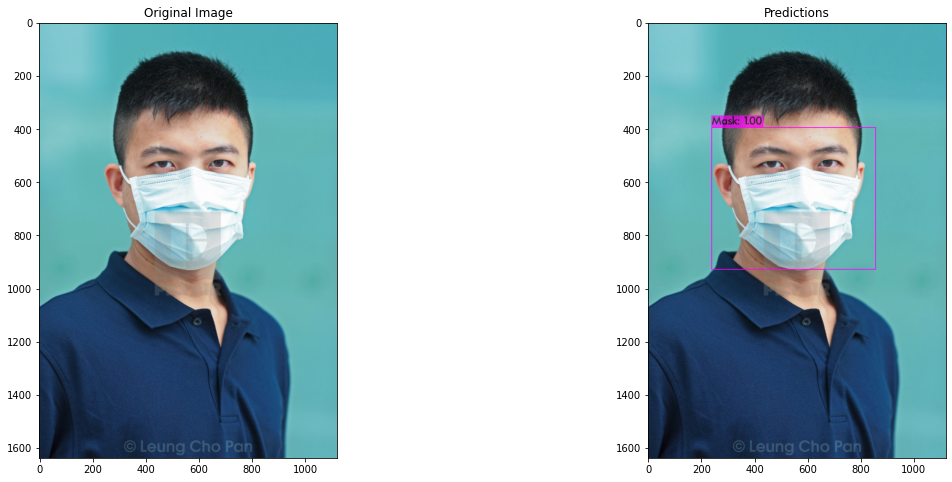

In [ ]:
!./darknet detector test yolov3-mask-setup.data yolov3-mask-test.cfg backup/yolov3-mask-train_best.weights ../Test/test-image1.jpg -thresh .6 2> /dev/null
display_output("../Test/test-image1.jpg")


<font style="color:green">8.2. Test Image 2</font>

net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 

 seen 64, trained: 236 K-images (3 Kilo-batches_64) 
 Detection layer: 82 - type = 28 
 Detection layer: 94 - type = 28 
 Detection layer: 106 - type = 28 
../Test/test-image2.jpg: Predicted in 103.914000 milli-seconds.
Mask: 99%
Mask: 100%
Mask: 98%
No-Mask: 100%
No-Mask: 85%
Mask: 93%


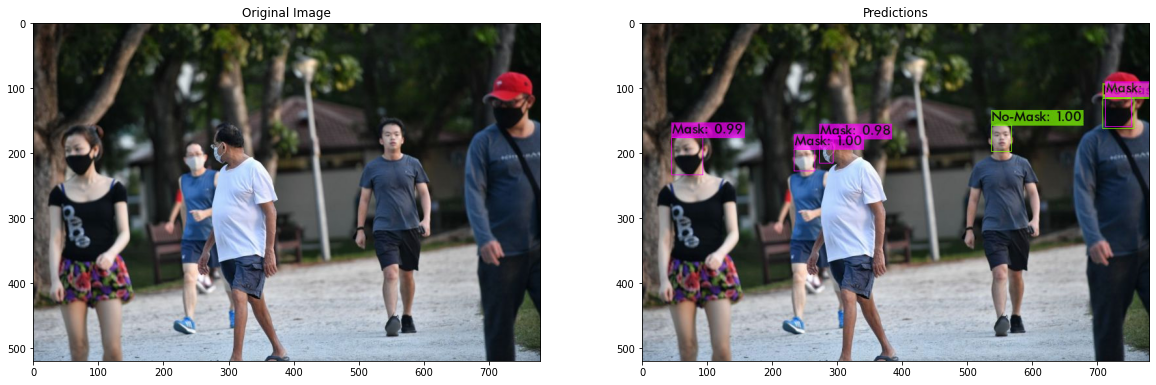

In [ ]:
!./darknet detector test yolov3-mask-setup.data yolov3-mask-test.cfg backup/yolov3-mask-train_best.weights ../Test/test-image2.jpg -thresh .6 2> /dev/null
display_output("../Test/test-image2.jpg")

### <font style="color:green">8.3. Test Image 3</font>

net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 

 seen 64, trained: 64 K-images (1 Kilo-batches_64) 
 Detection layer: 82 - type = 28 
 Detection layer: 94 - type = 28 
 Detection layer: 106 - type = 28 
../Test/test-image3.jpg: Predicted in 104.069000 milli-seconds.
Mask: 100%
Mask: 66%
Mask: 100%
No-Mask: 95%
Mask: 100%
Mask: 100%
Mask: 99%
Mask: 100%
Mask: 99%
Mask: 99%
Mask: 91%
Mask: 98%
Mask: 100%
Mask: 94%
Mask: 100%
Mask: 100%
Mask: 100%
Mask: 100%


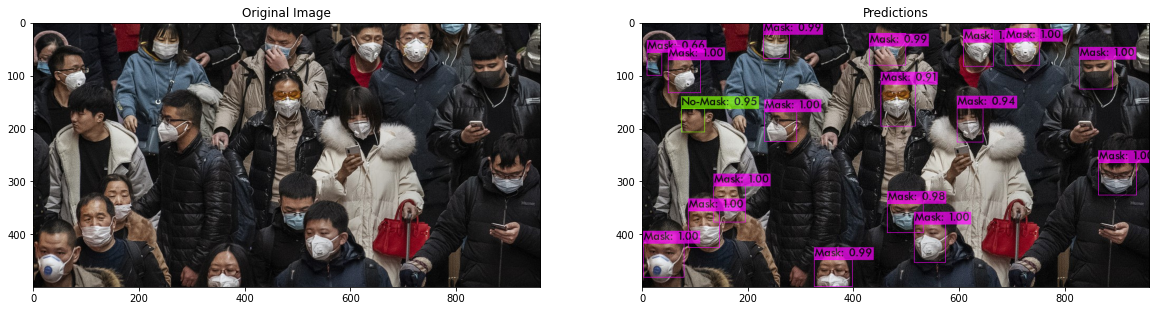

In [ ]:
!./darknet detector test yolov3-mask-setup.data yolov3-mask-test.cfg backup/yolov3-mask-train_best.weights ../Test/test-image3.jpg -thresh .6 2> /dev/null
display_output("../Test/test-image3.jpg")

### <font style="color:green">8.4. Test Image 4</font>

net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 

 seen 64, trained: 64 K-images (1 Kilo-batches_64) 
 Detection layer: 82 - type = 28 
 Detection layer: 94 - type = 28 
 Detection layer: 106 - type = 28 
../Test/test-image4.jpg: Predicted in 103.628000 milli-seconds.
No-Mask: 98%
Mask: 100%
Mask: 100%
No-Mask: 88%
Mask: 99%
Mask: 79%
Mask: 100%


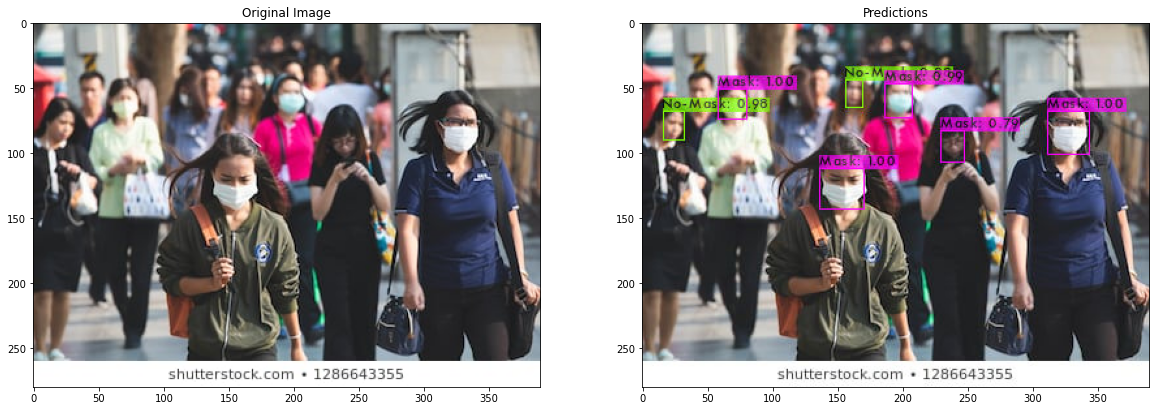

In [ ]:
!./darknet detector test yolov3-mask-setup.data yolov3-mask-test.cfg backup/yolov3-mask-train_best.weights ../Test/test-image4.jpg -thresh .6 2> /dev/null
display_output("../Test/test-image4.jpg")

### <font style="color:green">8.5. Running detection on video 1</font>

In [ ]:
!./darknet detector demo yolov3-mask-setup.data yolov3-mask-test.cfg backup/yolov3-mask-train_best.weights ../Test/test-video1.mp4 -thresh .6 -out_filename ../Test/video1_out.avi -dont_show 2> /dev/null

Streaming output truncated to the last 5000 lines.
Mask: 100% 
Mask: 100% 
Mask: 99% 
Mask: 88% 

FPS:31.9 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 99% 
Mask: 87% 

FPS:32.7 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 99% 
Mask: 86% 

FPS:32.1 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 86% 

FPS:32.8 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 87% 

FPS:33.2 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 87% 

FPS:33.6 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 87% 

FPS:33.7 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 87% 

FPS:33.4 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 99% 
Mask: 88% 

FPS:33.6 	 AVG_FPS:0.0

 cvWriteF

### <font style="color:green">8.6. Running detection on video 2</font>

In [ ]:
!./darknet detector demo yolov3-mask-setup.data yolov3-mask-test.cfg backup/yolov3-mask-train_best.weights ../Test/test-video2.mp4 -thresh .6 -out_filename ../Test/video2_out.avi -dont_show 2> /dev/null

Streaming output truncated to the last 5000 lines.
 cvWriteFrame 
Objects:

No-Mask: 100% 
No-Mask: 97% 
No-Mask: 88% 
No-Mask: 81% 
No-Mask: 81% 

FPS:34.9 	 AVG_FPS:30.7

 cvWriteFrame 
Objects:

No-Mask: 100% 
No-Mask: 97% 
No-Mask: 89% 
No-Mask: 83% 
No-Mask: 78% 
No-Mask: 64% 
No-Mask: 63% 

FPS:35.0 	 AVG_FPS:30.7

 cvWriteFrame 
Objects:

No-Mask: 100% 
No-Mask: 97% 
No-Mask: 96% 
No-Mask: 95% 
No-Mask: 90% 
No-Mask: 71% 
No-Mask: 64% 

FPS:34.7 	 AVG_FPS:31.7

 cvWriteFrame 
Objects:

No-Mask: 100% 
No-Mask: 99% 
No-Mask: 99% 
No-Mask: 96% 
No-Mask: 86% 
No-Mask: 72% 
No-Mask: 70% 
No-Mask: 67% 

FPS:34.6 	 AVG_FPS:31.7

 cvWriteFrame 
Objects:

No-Mask: 100% 
No-Mask: 100% 
No-Mask: 97% 
No-Mask: 97% 
No-Mask: 95% 
No-Mask: 94% 

FPS:34.1 	 AVG_FPS:31.7

 cvWriteFrame 
Objects:

No-Mask: 100% 
No-Mask: 100% 
No-Mask: 98% 
No-Mask: 98% 
No-Mask: 96% 
No-Mask: 95% 

FPS:34.0 	 AVG_FPS:31.7

 cvWriteFrame 
Objects:

No-Mask: 99% 
No-Mask: 99% 
No-Mask: 96% 
No-Mask: 95% 
No-Mask: